In [1]:
!pip install emoji
!pip install nltk
import nltk
nltk.download('stopwords')

     |████████████████████████████████| 185 kB 12.3 MB/s 
  Created wheel for emoji: filename=emoji-1.5.0-py3-none-any.whl size=187457 sha256=39589c7d817c837132a4e752369a47adfcbab2e5b150d0c331370b2fec71157e
  Stored in directory: /root/.cache/pip/wheels/db/b5/f6/b39abf14e94b3d6640613bbe630a66c10ccf7a12882d064fb5
Successfully built emoji
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [3]:
import tensorflow as tf 
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Embedding, SimpleRNN, Bidirectional
from keras.initializers import GlorotNormal, GlorotUniform
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [4]:
np.version.version

'1.19.5'

In [5]:
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


### Preparing Drive environment

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
os.getcwd()

'/content'

In [8]:
%cd drive/MyDrive/Galileo/RNN

/content/drive/MyDrive/Galileo/RNN


In [9]:
from NLPModule import TextCleaner

### Getting the data

In [10]:
output_path = './input/data'
dataset_path = './input/data/tweets_dataset.csv'
files_path = './input/tweets'

In [11]:
textCleaner = TextCleaner(output_path, dataset_path)

In [12]:
data = pd.read_csv('./input/data/cleaned_data.csv', encoding = 'utf-8')
data.dropna(subset = ['comments'], inplace = True, axis = 0)
data.loc[data.emotion == 'oov', 'emoji_icon'] = ''

In [13]:
data['emotion'].value_counts()

oov           2922453
notica         152189
alerta          95130
enfermedad      20713
cuidado         18505
disgusto        10055
risa             6168
miedo            4995
tristeza         2561
vacuna           2175
enojo             832
desafio           420
Name: emotion, dtype: int64

In [14]:
data = data.loc[data.emotion != 'oov', :]

In [15]:
comments = data['comments'].values

In [16]:
polarities = np.expand_dims(data['emotion'].values, axis = 1)
polarities.shape

(313743, 1)

In [17]:
ohe = OneHotEncoder()
labels = ohe.fit_transform(polarities).toarray()

In [18]:
np.expand_dims(ohe.categories_[0], axis = 1)

array([['alerta'],
       ['cuidado'],
       ['desafio'],
       ['disgusto'],
       ['enfermedad'],
       ['enojo'],
       ['miedo'],
       ['notica'],
       ['risa'],
       ['tristeza'],
       ['vacuna']], dtype=object)

In [19]:
ohe.transform(np.expand_dims(ohe.categories_[0], axis = 1)).toarray()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

### Preprocessing

In [20]:
oov_token = "<OOV>"
max_length = len(max(comments, key=len))
max_length

127

In [21]:
tokenizer = Tokenizer(lower = True, oov_token = oov_token)
tokenizer.fit_on_texts(comments)
word_index = tokenizer.word_index
X_seq = tokenizer.texts_to_sequences(comments)
X_pad = pad_sequences(X_seq, maxlen = max_length, padding = 'post', truncating = 'post')

In [22]:
vocab_size = len(word_index) + 1
vocab_size

33567

In [23]:
embedding_dim = 32

##### Train-test split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, labels, test_size = 0.3, random_state = 1)

In [25]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(219620, 127)
(219620, 11)
(94123, 127)
(94123, 11)


### Auxiliary Functions

In [26]:
def setModelResults():
    #Get model ID
    with open('./models/model_results.csv') as file:
        lines = file.readlines()  
    model_id = len(lines)
            
    #Prepare directory
    path = './models/' + 'rnn_model{}'.format(model_id)
    if not os.path.exists(path):
        os.makedirs(path)       
        
    return model_id

In [27]:
def writeModelResults(results):
    results.to_csv('./results/model_results.csv', mode = 'a', header = False, index = False)
    print('Model results saved succesfully')
    return 

### RNN Model

In [28]:
model_id = setModelResults()
model_id

3

##### Callbacks

In [29]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.90):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True

In [30]:
stop_cb = myCallback()

In [31]:
checkpoint_path = './models/rnn_model{}/weights_cp.ckpt'.format(model_id)

In [32]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 save_best_only = True,
                                                 verbose=1)

##### Model

In [33]:
model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length = max_length),
    SimpleRNN(32),
    Dense(32, activation = 'relu'), #tanh
    Dropout(0.3),
    Dense(11, activation = 'softmax') #return to 12 units if not excluding oov
])

In [34]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [35]:
model_path = './models/rnn_model{}/rnn_model.h5'.format(model_id)
model.save(model_path)

In [36]:
%%time
history = model.fit(X_train
                    ,y_train
                    ,epochs = 3
                    ,batch_size = 128
                    ,validation_split = 0.2
                    ,callbacks = [stop_cb, cp_callback]
                   )

Epoch 1/3
1373/1373 [==============================] - 218s 156ms/step - loss: 0.4238 - accuracy: 0.8788 - val_loss: 0.2047 - val_accuracy: 0.9377

Reached 90% accuracy so cancelling training!

Epoch 00001: val_accuracy improved from -inf to 0.93767, saving model to ./models/rnn_model3/weights_cp.ckpt
CPU times: user 5min 13s, sys: 59.8 s, total: 6min 13s
Wall time: 3min 38s


##### Evaluate training results

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 127, 32)           1074144   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                363       
Total params: 1,077,643
Trainable params: 1,077,643
Non-trainable params: 0
_________________________________________________________________


In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 0, 'epoch')

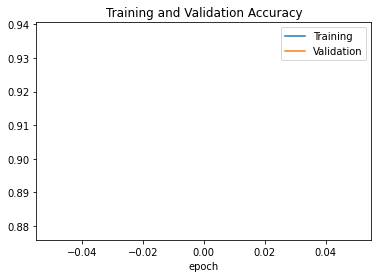

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

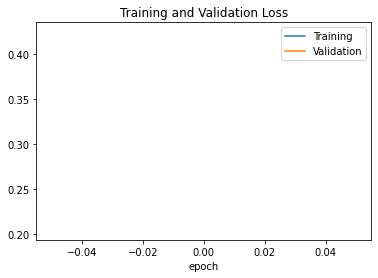

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

### Predictions

In [41]:
def predictLabels(model, X_test, y_test, ohe, mappings):
    emotions = ohe.categories_[0]
    probs = model.predict(X_test)
    class_prob = np.max(probs, axis = 1)
    predictions = emotions[np.argmax(probs, axis = 1)]
    pred_icon = [mappings[lbl] for lbl in predictions]
    
    labels = emotions[np.argmax(y_test, axis = 1)]
    icons = [mappings[lbl] for lbl in labels]
    match = predictions == labels
    
    results = pd.DataFrame({'Class_prediction': predictions, 'Class_prob': class_prob, 'Class_pred_icon': pred_icon,'Label': labels, 'Icon': icons,'Matches': match})
    return results, probs

In [42]:
results, probs = predictLabels(model, X_test, y_test, ohe, textCleaner.emoji_dictionary)

In [43]:
set(results['Class_prediction'].values)

{'alerta',
 'cuidado',
 'disgusto',
 'enfermedad',
 'miedo',
 'notica',
 'risa',
 'vacuna'}

In [44]:
results['comments'] = comments[list(results.index)]

In [45]:
results.loc[results.Matches == False, :]

,Class_prediction,Class_prob,Class_pred_icon,Label,Icon,Matches,comments
30,risa,0.234933,😂,enojo,😠,False,rt c5n begoña gómez esposa pedro sánchez pres...
32,risa,0.237539,😂,disgusto,😒,False,rt c5n begoña gómez esposa pedro sánchez pres...
38,risa,0.312868,😂,enfermedad,🤒,False,rt c5n begoña gómez esposa pedro sánchez pres...
51,alerta,0.203521,🚨,desafio,😎,False,rt c5n begoña gómez esposa pedro sánchez pres...
52,risa,0.200459,😂,enfermedad,🤒,False,rt c5n begoña gómez esposa pedro sánchez pres...
...,...,...,...,...,...,...,...
94074,disgusto,0.165294,😒,enfermedad,🤒,False,rt renzogaliano yordy reyna sometido examen ...
94094,risa,0.219179,😂,disgusto,😒,False,rt larepublica_pe loúltimo ipd suspende todas...
94107,risa,0.207772,😂,enojo,😠,False,rt rppnoticias imágenes causan indignación red...
94111,risa,0.192553,😂,miedo,😨,False,coronavirus perú cómo debe preparar empresa fr...


In [46]:
results['Class_prediction'].value_counts()

notica        45072
alerta        29842
cuidado        5713
enfermedad     5243
risa           4292
disgusto       2672
miedo          1003
vacuna          286
Name: Class_prediction, dtype: int64

In [47]:
test_acc = results['Matches'].sum() / results['Matches'].count()
print("Model RNN Test Accuracy={:.2%}".format(test_acc))

Model RNN Test Accuracy=93.53%


#### Save model results

In [48]:
results = pd.DataFrame({'Model_ID': model_id, 'Model_path': model_path, 'Weights_path': checkpoint_path, 'Accuracy': test_acc}, index = [0])
results

,Model_ID,Model_path,Weights_path,Accuracy
0,3,./models/rnn_model3/rnn_model.h5,./models/rnn_model3/weights_cp.ckpt,0.935266


In [49]:
results.to_csv('./models/model_results.csv', mode = 'a', header = False, index = False)

### Choose Best Model

In [50]:
models_df = pd.read_csv('./models/model_results.csv')
models_df.sort_values(by = 'Accuracy', ascending = False, ignore_index = True, inplace = True)
models_df.head()

,Model_ID,Model_path,Weights_path,Accuracy
0,3,./models/rnn_model3/rnn_model.h5,./models/rnn_model3/weights_cp.ckpt,0.935266
1,1,./models/rnn_model1/rnn_model.h5,./models/rnn_model1/weights_cp.ckpt,0.903074
2,2,./models/rnn_model2/rnn_model.h5,./models/rnn_model2/weights_cp.ckpt,0.485822


In [51]:
best_model = load_model(models_df.loc[0, 'Model_path'])
best_model.load_weights(models_df.loc[0, 'Weights_path'])

In [52]:
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print('Model RNN Test Accuracy={:.2%}'.format(accuracy))

Model RNN Test Accuracy=93.53%
